In [38]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics, svm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from yellowbrick.regressor import PredictionError


import warnings
warnings.filterwarnings('ignore')

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/subs_concatenated.csv')
df2 = pd.read_csv('/content/drive/MyDrive/subject_info.csv')

In [ ]:
df = pd.merge(df1, df2, on='SubjectID')

In [ ]:
df.columns.values

In [ ]:
df.drop(columns=[x for x in df.columns.values if (('acc2' in x)|('orientation' in x))], inplace=True)
df.isna().sum()

In [ ]:
fill_frames = []

for subs in df['SubjectID'].unique():
  subs_df = df[df['SubjectID']==subs]
  for acts in subs_df['activityID'].unique():
    subsact_df = subs_df[subs_df['activityID']==acts]
    subsact_df['heart_rate'].fillna(method = 'ffill', inplace = True)
    subsact_df['heart_rate'].fillna(method = 'bfill', inplace = True)
    fill_frames.append(subsact_df)

df = pd.concat(fill_frames)
df.dropna(subset=['heart_rate'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.isna().sum()

In [ ]:
df['MET'] = [1]*len(df)

mets = {1: 1.0, 2: 1.8, 3: 1.8, 4: 3.5, 5: 8.0, 6: 4.0, 7: 6.0, 12: 8.0, 13: 3.0, 16: 3.5, 17: 2.3, 24: 10}

for i in range(len(df)):
  df['MET'].iloc[i]=mets[df['activityID'].iloc[i]]

df.head()

,timestamp,activityID,heart_rate,IMUhtemp,IMUhacc1x,IMUhacc1y,IMUhacc1z,IMUhgyrx,IMUhgyry,IMUhgyrz,...,IMUamagx,IMUamagy,IMUamagz,SubjectID,Age,Height,Weight,Resting_HR,Max_HR,MET
0,37.66,1,100.0,30.375,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,...,-61.1081,-36.8636,-58.3696,1,27,182,83,75,193,1.0
1,37.67,1,100.0,30.375,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,...,-60.8916,-36.3197,-58.3656,1,27,182,83,75,193,1.0
2,37.68,1,100.0,30.375,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,...,-60.3407,-35.7842,-58.6119,1,27,182,83,75,193,1.0
3,37.69,1,100.0,30.375,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,...,-60.7646,-37.1028,-57.8799,1,27,182,83,75,193,1.0
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,...,-60.2040,-37.1225,-57.8847,1,27,182,83,75,193,1.0


In [ ]:
df.columns.values

array(['timestamp', 'activityID', 'heart_rate', 'IMUhtemp', 'IMUhacc1x',
       'IMUhacc1y', 'IMUhacc1z', 'IMUhgyrx', 'IMUhgyry', 'IMUhgyrz',
       'IMUhmagx', 'IMUhmagy', 'IMUhmagz', 'IMUctemp', 'IMUcacc1x',
       'IMUcacc1y', 'IMUcacc1z', 'IMUcgyrx', 'IMUcgyry', 'IMUcgyrz',
       'IMUcmagx', 'IMUcmagy', 'IMUcmagz', 'IMUatemp', 'IMUaacc1x',
       'IMUaacc1y', 'IMUaacc1z', 'IMUagyrx', 'IMUagyry', 'IMUagyrz',
       'IMUamagx', 'IMUamagy', 'IMUamagz', 'SubjectID', 'Age', 'Height',
       'Weight', 'Resting_HR', 'Max_HR', 'MET'], dtype=object)

In [ ]:
df.groupby(['SubjectID'], as_index=False).count()

,SubjectID,timestamp,activityID,heart_rate,IMUhtemp,IMUhacc1x,IMUhacc1y,IMUhacc1z,IMUhgyrx,IMUhgyry,...,IMUagyrz,IMUamagx,IMUamagy,IMUamagz,Age,Height,Weight,Resting_HR,Max_HR,MET
0,1,249957,249957,249957,248599,248599,248599,248599,248599,248599,...,248859,248859,248859,248859,249957,249957,249957,249957,249957,249957
1,2,263349,263349,263349,260902,260902,260902,260902,260902,260902,...,261772,261772,261772,261772,263349,263349,263349,263349,263349,263349
2,3,174338,174338,174338,173851,173851,173851,173851,173851,173851,...,173928,173928,173928,173928,174338,174338,174338,174338,174338,174338
3,4,231420,231420,231420,229261,229261,229261,229261,229261,229261,...,230593,230593,230593,230593,231420,231420,231420,231420,231420,231420
4,5,272442,272442,272442,271021,271021,271021,271021,271021,271021,...,270880,270880,270880,270880,272442,272442,272442,272442,272442,272442
5,6,250096,250096,250096,249243,249243,249243,249243,249243,249243,...,249110,249110,249110,249110,250096,250096,250096,250096,250096,250096
6,7,232776,232776,232776,231385,231385,231385,231385,231385,231385,...,231920,231920,231920,231920,232776,232776,232776,232776,232776,232776
7,8,262102,262102,262102,261096,261096,261096,261096,261096,261096,...,260914,260914,260914,260914,262102,262102,262102,262102,262102,262102
8,9,6391,6391,6391,6389,6389,6389,6389,6389,6389,...,6388,6388,6388,6388,6391,6391,6391,6391,6391,6391


In [ ]:
df.isna().sum()

In [ ]:
df.shape

(1942871, 40)

In [ ]:
df.drop(index=list(df[df['SubjectID']==9].index), inplace=True)
df.reset_index(drop=True, inplace=True)
df['BMI'] = df['Weight']/(df['Height']**2)

In [ ]:
activity_key = {1: 'lying', 2: 'sitting', 3: 'standing', 4: 'walking', 5: 'running', 6: 'cycling',
                7: 'Nordic walking', 9: 'watching TV', 10: 'computer work', 11: 'car driving', 
                12: 'ascending stairs', 13: 'descending stairs', 16: 'vacuum cleaning', 17: 'ironing', 
                18: 'folding laundry', 19: 'house cleaning', 20: 'playing soccer', 24: 'rope jumping'}

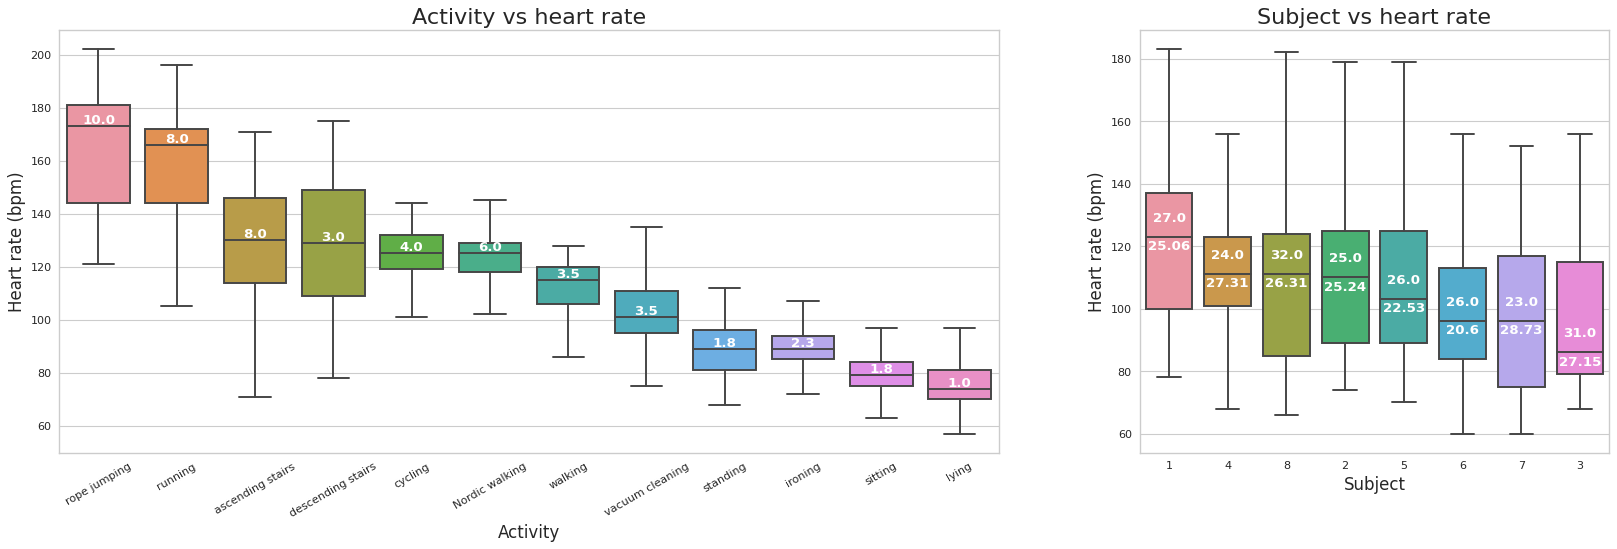

In [173]:
fig, ax = plt.subplots(1, 2, figsize=(25,7), dpi= 80, gridspec_kw={'width_ratios': [2, 1]})

act_order_df = df.groupby(['activityID'], as_index=False)['heart_rate', 'MET'].median().sort_values(['heart_rate'], ascending=False)
sub_order_df = df.groupby(['SubjectID'], as_index=False)['heart_rate', 'BMI', 'Age'].median().sort_values(['heart_rate'], ascending=False)

sub_order_df['BMI'] = pd.Series([round(x*10000,2) for x in sub_order_df['BMI']])

act_order = act_order_df['activityID']
sub_order = sub_order_df['SubjectID']

sns.set_style('darkgrid')


a1 = sns.boxplot(x='activityID', y='heart_rate', data=df, ax=ax[0], showfliers=False, order=act_order)

for x1tick in a1.get_xticks():
    a1.text(x1tick,act_order_df['heart_rate'][act_order.index[x1tick]]+1,act_order_df['MET'][act_order.index[x1tick]], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')
    
a1.set_xticklabels([activity_key[x] for x in act_order], rotation=30)
a1.set_title('Activity vs heart rate', fontsize=20)
a1.set_xlabel('Activity', fontsize=15)
a1.set_ylabel('Heart rate (bpm)', fontsize=15)


a2 = sns.boxplot(x='SubjectID', y='heart_rate', data=df, ax=ax[1], showfliers=False, order=sub_order)

for x1tick in a2.get_xticks():
    a2.text(x1tick,sub_order_df['heart_rate'][sub_order.index[x1tick]]+5,sub_order_df['Age'][sub_order.index[x1tick]], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')
    a2.text(x1tick,sub_order_df['heart_rate'][sub_order.index[x1tick]]-4,sub_order_df['BMI'][sub_order.index[x1tick]], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')

a2.set_title('Subject vs heart rate', fontsize=20)
a2.set_xlabel('Subject', fontsize=15)
a2.set_ylabel('Heart rate (bpm)', fontsize=15)


# sns.boxplot(x='activityID', y='heart_rate', data=df, ax=ax[0], showfliers=False)
# sns.boxplot(x='SubjectID', y='heart_rate', data=df, ax=ax[1], showfliers=False)

plt.show()

In [40]:
df['IMUhaccnet'] = (df['IMUhacc1x']**2 + df['IMUhacc1y']**2 + df['IMUhacc1z']**2)**0.5
df['IMUcaccnet'] = (df['IMUcacc1x']**2 + df['IMUcacc1y']**2 + df['IMUcacc1z']**2)**0.5
df['IMUaaccnet'] = (df['IMUaacc1x']**2 + df['IMUaacc1y']**2 + df['IMUaacc1z']**2)**0.5

df['IMUhgyrnet'] = (df['IMUhgyrx']**2 + df['IMUhgyry']**2 + df['IMUhgyrz']**2)**0.5
df['IMUcgyrnet'] = (df['IMUcgyrx']**2 + df['IMUcgyry']**2 + df['IMUcgyrz']**2)**0.5
df['IMUagyrnet'] = (df['IMUagyrx']**2 + df['IMUagyry']**2 + df['IMUagyrz']**2)**0.5

df['IMUhmagnet'] = (df['IMUhmagx']**2 + df['IMUhmagy']**2 + df['IMUhmagz']**2)**0.5
df['IMUcmagnet'] = (df['IMUcmagx']**2 + df['IMUcmagy']**2 + df['IMUcmagz']**2)**0.5
df['IMUamagnet'] = (df['IMUamagx']**2 + df['IMUamagy']**2 + df['IMUamagz']**2)**0.5

df.drop(columns=['IMUhacc1x', 'IMUhacc1y', 'IMUhacc1z', 'IMUhgyrx', 'IMUhgyry', 'IMUhgyrz',
       'IMUhmagx', 'IMUhmagy', 'IMUhmagz', 'IMUcacc1x',
       'IMUcacc1y', 'IMUcacc1z', 'IMUcgyrx', 'IMUcgyry', 'IMUcgyrz',
       'IMUcmagx', 'IMUcmagy', 'IMUcmagz', 'IMUaacc1x',
       'IMUaacc1y', 'IMUaacc1z', 'IMUagyrx', 'IMUagyry', 'IMUagyrz',
       'IMUamagx', 'IMUamagy', 'IMUamagz'], inplace=True)

In [43]:
df = df[['timestamp', 'activityID', 'heart_rate', 'IMUhtemp', 'IMUctemp',
       'IMUatemp', 'IMUhaccnet', 'IMUcaccnet', 'IMUaaccnet',
       'IMUhgyrnet', 'IMUcgyrnet', 'IMUagyrnet', 'IMUhmagnet',
       'IMUcmagnet', 'IMUamagnet', 'SubjectID', 'Age', 'Height', 'Weight', 'Resting_HR',
       'Max_HR', 'MET', 'BMI']]

df.head()

,timestamp,activityID,heart_rate,IMUhtemp,IMUctemp,IMUatemp,IMUhaccnet,IMUcaccnet,IMUaaccnet,IMUhgyrnet,...,IMUcmagnet,IMUamagnet,SubjectID,Age,Height,Weight,Resting_HR,Max_HR,MET,BMI
0,37.66,1,100.0,30.375,32.1875,30.75,10.230952,9.791172,9.912723,0.039483,...,67.332172,92.196177,1,27,182,83,75,193,1.0,0.002506
1,37.67,1,100.0,30.375,32.1875,30.75,9.855324,9.791979,9.879026,0.173852,...,66.692157,91.833822,1,27,182,83,75,193,1.0,0.002506
2,37.68,1,100.0,30.375,32.1875,30.75,9.496016,9.907409,9.885166,0.238506,...,67.164701,91.415884,1,27,182,83,75,193,1.0,0.002506
3,37.69,1,100.0,30.375,32.1875,30.75,9.526437,9.879549,9.839102,0.194311,...,66.494381,91.755312,1,27,182,83,75,193,1.0,0.002506
4,37.70,1,100.0,30.375,32.1875,30.75,9.751993,9.875840,9.956473,0.072467,...,66.439341,91.396062,1,27,182,83,75,193,1.0,0.002506


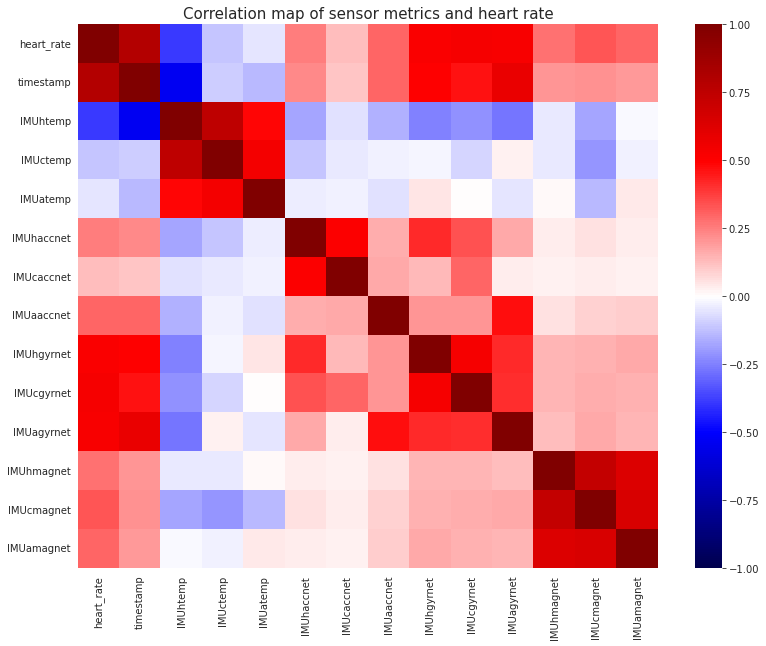

In [44]:
plt.figure(figsize=(13,10))

sns.heatmap(df[['heart_rate', 'timestamp']+[x for x in df.columns.values if 'IMU' in x]].corr(), cmap='seismic', vmin=-1)
plt.title('Correlation map of sensor metrics and heart rate', fontsize=15)

plt.show()

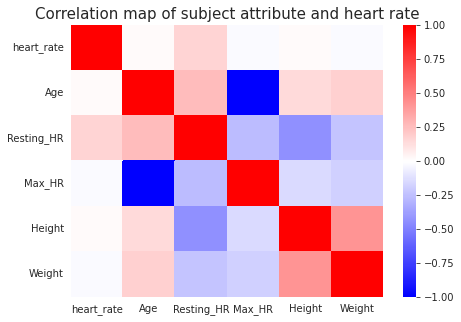

In [45]:
plt.figure(figsize=(7,5))

sns.heatmap(df[['heart_rate', 'Age', 'Resting_HR', 'Max_HR', 'Height', 'Weight']].corr(), cmap='bwr')
plt.title('Correlation map of subject attribute and heart rate', fontsize=15)

plt.show()

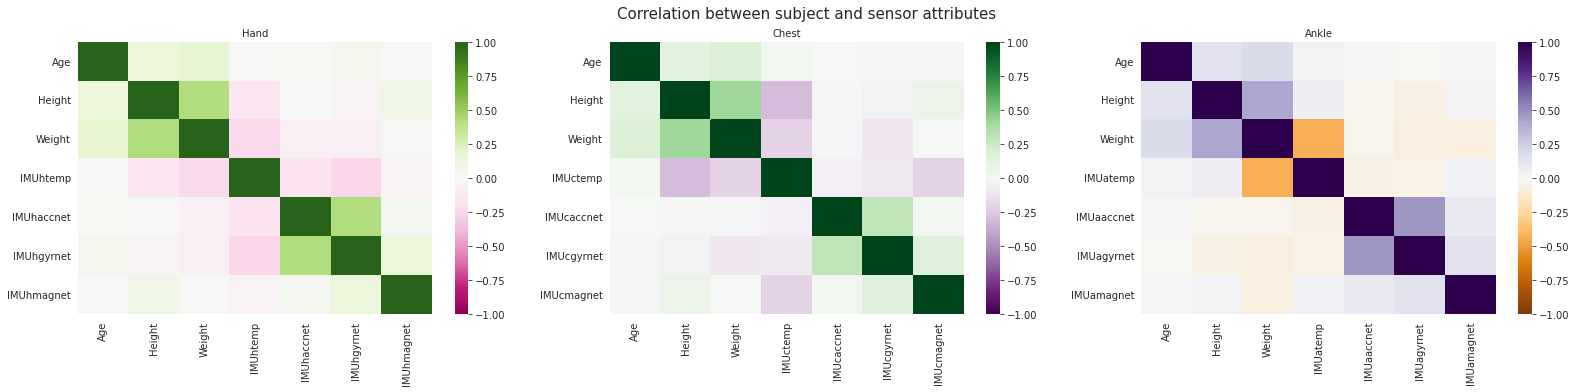

In [46]:
plt.figure(figsize=(27,5))

plt.subplot(1,3,1)
sns.heatmap(df[['Age','Height', 'Weight']+[x for x in df.columns.values if 'IMUh' in x]].corr(), cmap='PiYG', vmin=-1)
plt.title('Hand', fontsize=10)

plt.subplot(1,3,2)
sns.heatmap(df[['Age', 'Height', 'Weight']+[x for x in df.columns.values if 'IMUc' in x]].corr(), cmap='PRGn', vmin=-1)
plt.title('Chest', fontsize=10)

plt.subplot(1,3,3)
sns.heatmap(df[['Age', 'Height', 'Weight']+[x for x in df.columns.values if 'IMUa' in x]].corr(), cmap='PuOr', vmin=-1)
plt.title('Ankle', fontsize=10)


plt.suptitle('Correlation between subject and sensor attributes', fontsize= 15)
plt.show()

In [48]:
df['starting_HR'] = [np.nan]*len(df)
frames = []
for subid in df['SubjectID'].unique():
  sliced_df = df[df['SubjectID']==subid]
  sl_indexes = sliced_df.index
  sliced_df['starting_HR'].loc[sl_indexes[0]] = sliced_df['heart_rate'].loc[sl_indexes[0]]
  for i in range(1, len(sl_indexes)-1):
    if sliced_df['activityID'].loc[sl_indexes[i]]!=sliced_df['activityID'].loc[sl_indexes[i+1]]:
      sliced_df['starting_HR'].loc[sl_indexes[i+1]] = sliced_df['heart_rate'].loc[sl_indexes[i]]

  frames.append(sliced_df)

df = pd.concat(frames)
df['starting_HR'].fillna(method = 'ffill', inplace = True)

In [116]:
features = [x for x in df.columns.values if ((abs(df['heart_rate'].corr(df[x]))>0.20) & (abs(df['heart_rate'].corr(df[x]))<1))]
features = [x for x in features if (('MET' not in x)&('ID' not in x))]
values = ['heart_rate']
features

['IMUhaccnet',
 'IMUcgyrnet',
 'starting_HR',
 'IMUhmagnet',
 'IMUaaccnet',
 'IMUhgyrnet',
 'IMUhtemp',
 'timestamp',
 'IMUcmagnet',
 'IMUagyrnet',
 'IMUamagnet']

In [117]:
df.isna().sum()

timestamp          0
activityID         0
heart_rate         0
IMUhtemp       11122
IMUctemp        2420
IMUatemp        8504
IMUhaccnet     11122
IMUcaccnet      2420
IMUaaccnet      8504
IMUhgyrnet     11122
IMUcgyrnet      2420
IMUagyrnet      8504
IMUhmagnet     11122
IMUcmagnet      2420
IMUamagnet      8504
SubjectID          0
Age                0
Height             0
Weight             0
Resting_HR         0
Max_HR             0
MET                0
BMI                0
starting_HR        0
dtype: int64

In [51]:
t_df = df.copy()
tframes = []
for sub in t_df['SubjectID'].unique():
  sdf = t_df[t_df['SubjectID']==sub]
  for act in sdf['activityID'].unique():
    nsdf = sdf[sdf['activityID']==act]

    st_time = nsdf['timestamp'].loc[nsdf.index[0]]
    nsdf['st_time'] = [st_time]*len(nsdf['timestamp'])
    tot_time = nsdf['timestamp'].loc[nsdf.index[len(nsdf.index)-1]]-nsdf['timestamp'].loc[nsdf.index[0]]

    rest_hr = nsdf['Resting_HR'].loc[nsdf.index[0]]
    tot_hr = nsdf['Max_HR'].loc[nsdf.index[0]]-nsdf['Resting_HR'].loc[nsdf.index[0]]
    if tot_time==0:
      nsdf['timestamp'].loc[nsdf.index[0]] = 0.0
    else:
      nsdf['timestamp'] = (nsdf['timestamp']-nsdf['st_time'])/tot_time
      
    nsdf['heart_rate'] = (nsdf['heart_rate']-nsdf['Resting_HR'])/tot_hr
    nsdf['starting_HR'] = (nsdf['starting_HR']-nsdf['Resting_HR'])/tot_hr


    r_mean_list = [x for x in nsdf.columns.values if (('IMU' in x)&('temp' not in x))]
    for item in r_mean_list:
      try:
        result_add = seasonal_decompose(nsdf[item], model='additive', period=1000, extrapolate_trend='freq')
        nsdf[item] = result_add.trend
      except:
        pass
    
    try:
      nsdf['heart_rate'] = seasonal_decompose(nsdf['heart_rate'], model='additive', period=100, extrapolate_trend='freq').trend
    except:
      pass

    nsdf.drop(columns=['st_time'], inplace=True)
    # nsdf.dropna(subset=['heart_rate'], inplace=True)
    tframes.append(nsdf)

t_df = pd.concat(tframes)
t_df.reset_index(drop=True, inplace=True)
t_df['activityID'] = pd.Categorical(t_df.activityID)
t_df['SubjectID'] = pd.Categorical(t_df.SubjectID)
t_df['MET'] = pd.Categorical(t_df.MET)

In [52]:
t_df.isna().sum()

timestamp          0
activityID         0
heart_rate         0
IMUhtemp       11122
IMUctemp        2420
IMUatemp        8504
IMUhaccnet     11122
IMUcaccnet      2420
IMUaaccnet      8504
IMUhgyrnet     11122
IMUcgyrnet      2420
IMUagyrnet      8504
IMUhmagnet     11122
IMUcmagnet      2420
IMUamagnet      8504
SubjectID          0
Age                0
Height             0
Weight             0
Resting_HR         0
Max_HR             0
MET                0
BMI                0
starting_HR        0
dtype: int64

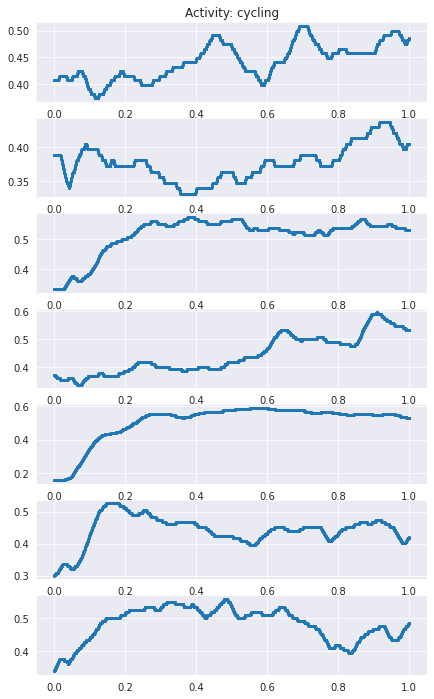

In [54]:
plt.figure(figsize=(7,12))
test_act = np.random.choice(list(df['activityID'].unique()))
act_df = t_df[t_df['activityID']==test_act]
spi = 1
for i in act_df['SubjectID'].unique():
  df_t = act_df[act_df['SubjectID']==i]
  plt.subplot(len(act_df['SubjectID'].unique()),1, spi)
  plt.scatter(df_t['timestamp'], df_t['heart_rate'].rolling(1).mean(), alpha=0.3, s=2)
  if spi==1:
    plt.title('Activity: '+activity_key[test_act])
  spi+=1

plt.show()

In [167]:
# subject_no = 3
act = 24

# act = np.random.choice(t_df['activityID'].unique())
subject_no = np.random.choice(list(t_df[t_df['activityID']==act].SubjectID.unique()))

train = t_df[t_df['SubjectID']!=subject_no]
test = t_df[t_df['SubjectID']==subject_no]

train3 = train[train['activityID']==act]
test3 = test[test['activityID']==act]

x_train = train3[features]
y_train = train3[values]
x_test = test3[features]
y_test = test3[values]

x_val = x_test['timestamp']

In [168]:
imp_reg = LinearRegression()
imp = IterativeImputer(estimator=imp_reg, sample_posterior=False, verbose=2, max_iter=200, tol=1e-10, imputation_order='roman')

In [ ]:
x_train = pd.DataFrame(imp.fit_transform(x_train), columns=x_train.columns.values)
x_test = pd.DataFrame(imp.transform(x_test), columns=x_test.columns.values)

In [170]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns.values)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns.values)

In [171]:
model = RandomForestRegressor(max_depth=10, max_features='log2', n_jobs=-1)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

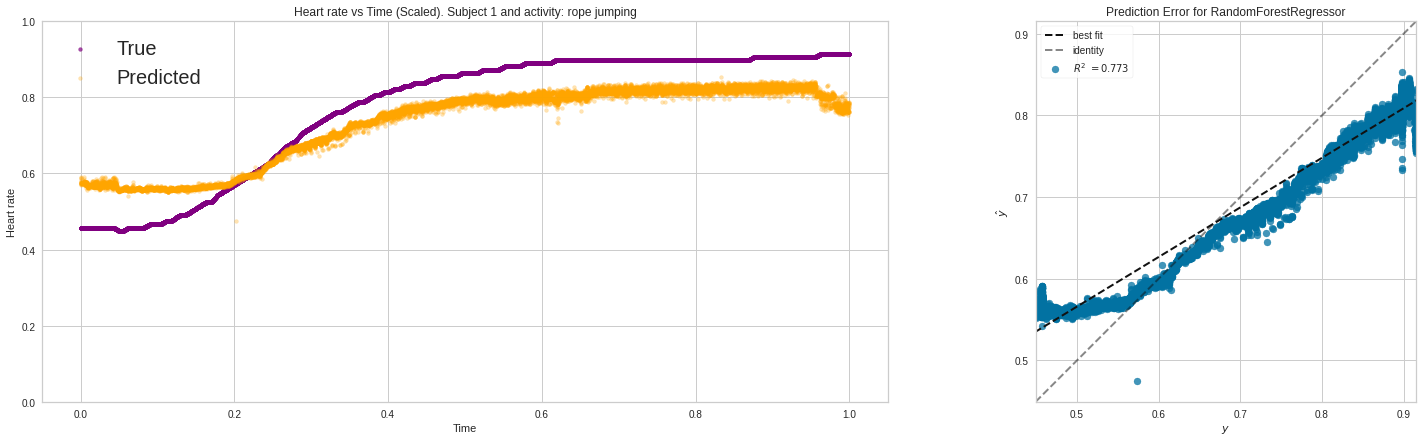

<Figure size 576x396 with 0 Axes>

In [172]:
fig, axs = plt.subplots(1,2,figsize=(25,7), gridspec_kw={'width_ratios': [2, 1]})
y_true = list(y_test['heart_rate'])
mse = mean_squared_error(y_true,y_pred)

axs[0].scatter(x_val, y_true, color='purple', alpha=0.7, label='True', s=15)
axs[0].scatter(x_val, y_pred, color='orange', alpha=0.3, label='Predicted', s=15)
axs[0].legend(prop={'size': 20})
axs[0].set_title('Heart rate vs Time (Scaled). Subject '+str(subject_no)+' and activity: '+activity_key[act])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Heart rate')
axs[0].set_ylim([0, max(1, max(y_true))])


axs[1] = PredictionError(model)

axs[1].fit(x_train, y_train)
axs[1].score(x_test, y_true)
axs[1].show()


plt.suptitle('True values vs Predicted values (Random Forest regression): Subject '+str(subject_no)+' and activity: '+activity_key[act], fontsize=15)
plt.show()